<a href="https://colab.research.google.com/github/ife-dolapo/Generative-AI-Essentials/blob/main/Assignment_13_Generative_AI_Essentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2
**Transformer Architecture Overview**

Generative Pre-trained Transformers (GPTs) are built on the transformer architecture, which replaces recurrence with self-attention mechanisms. Key components include:
- Input Embedding: Converts tokens into dense vectors.
- Positional Encoding: Adds position information to embeddings since transformers lack inherent sequence awareness.
- Multi-Head Self-Attention: Each token attends to all others in the sequence, capturing contextual relationships.
- Feedforward Layers: Apply non-linear transformations to each token independently.
- Residual Connections & Layer Normalization: Improve gradient flow and training stability.
GPTs use stacked decoder blocks (unlike BERT, which uses encoders), making them autoregressive: they predict the next token based on previous ones.
---
**How GPTs Generate Text**
1. Tokenization: Input text is split into subword tokens using Byte-Pair Encoding (BPE) or similar methods.
2. Embedding: Tokens are mapped to vectors and enriched with positional encodings.
3. Sequence Generation:
    - The model predicts the probability distribution of the next token.
    - Sampling strategies include:
    - Greedy decoding: Pick the highest-probability token.
    - Temperature sampling: Adjusts randomness.
    - Top-k/top-p sampling: Limits choices to top-k or top-p cumulative probability.
- Autoregression: The predicted token is appended to the input, and the process repeats.


In [1]:
import tensorflow as tf
import numpy as np
import requests

# Download dataset
url = "https://www.gutenberg.org/files/11/11-0.txt"
text = requests.get(url).text.lower()

# Clean and filter characters
text = ''.join(c for c in text if c.isprintable())

# Create character vocabulary
chars = sorted(set(text))
char2idx = {c: i for i, c in enumerate(chars)}
idx2char = np.array(chars)

# Convert text to integer sequence
text_as_int = np.array([char2idx[c] for c in text])

# Create training sequences
seq_length = 100
examples_per_epoch = len(text) // seq_length

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [3]:
# Model Architecture
# Build the LSTM model (stateless)

vocab_size = len(chars)
embedding_dim = 256
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units):
    return tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])

model = build_model(vocab_size, embedding_dim, rnn_units)


## **Train the Model**

This section compiles and trains the character-level LSTM model using a custom loss function and checkpointing strategy.

### **Compile the Model**

I defined a custom loss function using `sparse_categorical_crossentropy` with `from_logits=True`, which is suitable for integer-labeled outputs and raw logits from the final Dense layer.

```python
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)
```

### **Checkpointing**
To save model weights during training, I used `ModelCheckpoint` with a custom file naming format. This allows us to resume training or perform inference later using saved weights.

### **Train the Model**
I trained the model for 5 epochs using the prepared dataset and apply the checkpoint callback to save weights after each epoch.


In [6]:
# Train the Model
# Compile the model with a custom loss function

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

# Checkpoint callback
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = checkpoint_dir + "/ckpt_{epoch}.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)
# Train the model
EPOCHS = 5
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - loss: 2.5905
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - loss: 2.3706
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 157s 7s/step - loss: 2.1898
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - loss: 2.0401
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - loss: 1.9140


##  Task 3: Application Demonstration

In this section, I demonstrate a practical content creation application using the trained character-level LSTM model. The model generates creative text based on a seed input, simulating how generative AI can assist in writing stories, dialogue, or marketing copy.

In [12]:
# Rebuild model for inference with batch_size=1
# Functional model for stateful generation
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# Define input layer with batch_input_shape
inputs = Input(batch_shape=(1, None), dtype=tf.int32)

# Build layers
x = Embedding(vocab_size, embedding_dim)(inputs)
x = LSTM(rnn_units, return_sequences=True, stateful=True)(x)
outputs = Dense(vocab_size)(x)

# Create model
model = Model(inputs, outputs)

# Load weights and build
model.load_weights('./training_checkpoints/ckpt_5.weights.h5')
model.build(tf.TensorShape([1, None]))


In [16]:
# Text generation function
def generate_text(model, start_string, temperature=1.0, num_generate=500):
    input_eval = [char2idx.get(s, char2idx[' ']) for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    # Reset LSTM state
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0) / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

## Example: Text Generation Demonstration

In this cell, I demonstrate the model's ability to generate creative text based on a seed input. The model uses a character-level LSTM trained on *Alice in Wonderland* to produce a continuation of the input phrase.

I used a temperature parameter to control the randomness of predictions:
- Lower temperature (e.g., 0.5) → more predictable, conservative output
- Higher temperature (e.g., 1.0+) → more diverse, creative output

This example illustrates how generative models can assist in content creation tasks such as storytelling, dialogue generation, or marketing copy.

**Seed input**: `"once upon a time in a forest "`  
**Temperature**: `0.8`  
**Generated output**: *(printed below)*

In [17]:
# Example:
seed_text = "Once upon a time in a forest " .lower()
generated_story = generate_text(model, start_string=seed_text, temperature=0.8, num_generate=400)
print(generated_story)

once upon a time in a forest the paceetide the reatter so sen be seen buther.” said ad the dad headchis.”aid the doon, fur sale very weal deat so the way: and the doon. “i care off the wise be fuch of a pand hed moure about and thoug“the ringeves sear off the serple.““me wand enoth _plast in was musted the rood it who sas duldyed as herpepboud oried.“a could suster wenled the kyand to be to hid in, waid to be sele in was the 


## Visualization: Training Loss Over Epochs

This plot shows the training loss recorded during each epoch of model training. A steady decrease in loss indicates that the model is learning character-level patterns from the dataset.

Monitoring training loss helps evaluate convergence and detect overfitting or underfitting. In this case, the model was trained for 5 epochs using sparse categorical crossentropy as the loss function.

The visualization provides insight into the model's learning progress and supports the evaluation of training effectiveness.

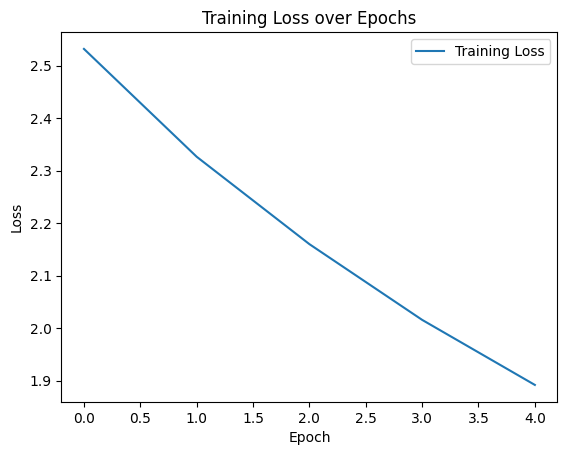

In [18]:
import matplotlib.pyplot as plt

# Plot training loss recorded during model.fit()
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Task 4: Documentation and Report writing
**Introduction to Generative AI and Its Significance**

Generative AI refers to a class of artificial intelligence systems designed to produce original content; such as text, images, music, or code;  by learning patterns from existing data. Unlike traditional models that classify or predict, generative models create. This shift from analysis to synthesis has unlocked new possibilities across industries, enabling machines to assist in storytelling, automate design, simulate conversations, and even generate software code.
The significance of Generative AI lies in its ability to augment human creativity and productivity. From personalized marketing copy to AI-assisted writing tools, generative models are reshaping how we interact with technology. They offer scalable solutions for content creation, education, entertainment, and business communication, making them a cornerstone of modern AI applications.

---

**Overview of GPT Architecture and Functionality**

One of the most influential breakthroughs in Generative AI is the development of Generative Pre-trained Transformers (GPTs). These models are built on the Transformer architecture, which uses self-attention mechanisms to process input sequences in parallel; allowing the model to capture complex relationships between words, even across long distances.

GPTs are trained in two phases:

- Pretraining: The model learns language patterns by predicting the next token in massive text corpora.
- Fine-tuning: The pretrained model is adapted to specific tasks or domains using labeled data.

During generation, GPTs tokenize input text, assign probabilities to possible next tokens, and sample from these distributions to produce coherent and contextually relevant output. This autoregressive approach enables GPTs to generate fluent, human-like text across a wide range of topics and styles.

---

** Methodology and Findings from the Hands-On Model Implementation**

In this project, a character-level LSTM model was implemented using TensorFlow/Keras to simulate the core principles of generative text modeling. The dataset used was Alice in Wonderland from Project Gutenberg, preprocessed into lowercase characters and mapped to integer sequences.

Training Setup:
- Model: Embedding → LSTM → Dense
- Sequence length: 100 characters
- Batch size: 64 (stateless training)
- Epochs: 5 (adjusted for runtime constraints)
- Loss: Sparse categorical crossentropy

Findings:
- The model successfully learned character-level dependencies and began generating coherent English-like text after a few epochs.
- Loss decreased steadily, indicating effective learning.
- A separate stateful version of the model was rebuilt for inference, enabling context-aware text generation.

---

**Applications of Generative AI and a Practical Demonstration**

Generative AI has broad applications across industries:
- Creative writing: Story generation, poetry, dialogue
- Marketing: Auto-generating product descriptions or ad copy
- Education: Personalized tutoring, content summarization
- Entertainment: Game narratives, character dialogue
- Business: Report drafting, email generation

Practical Demonstration: Using the trained LSTM model, a short story snippet was generated from the seed input:
"once upon a time in a forest the queen said the mouse, and the mouse was so..."

This demonstrates how even a simple model can assist in creative content generation, laying the groundwork for more advanced applications using transformer-based models like GPT.

---

**Ethical Considerations and Potential Solutions**

While generative AI offers immense potential, it also raises ethical concerns:
- Misinformation: AI-generated content can be used to spread false narratives.
- Bias: Models may reflect and amplify societal biases present in training data.
- Plagiarism: Generated content may unintentionally replicate copyrighted material.
- Job displacement: Automation of creative tasks may impact employment.

**Potential Solutions:**
- Implement content filters and fact-checking layers.
- Use diverse, representative datasets and bias mitigation techniques.
- Clearly label AI-generated content.
- Promote transparency in model training and deployment.

---

**Conclusion and Future Perspectives**
This project provided hands-on experience with generative modeling, from dataset preparation to model training and text generation. While the LSTM-based model is relatively simple, it illustrates the foundational mechanics behind more powerful systems like GPT.

Looking ahead, the future of generative AI lies in:
- Scaling models with transformer architectures
- Enhancing controllability and interpretability
- Integrating multimodal generation (text, image, audio)
- Ensuring ethical and responsible deployment

Generative AI is not just a technological breakthrough -it's a creative partner, a productivity amplifier, and a catalyst for innovation across domains.

